# Step 1: Loading LendingClub Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

# Filtering the relevant Loan Statuses

In [3]:
final_status = ['Fully Paid', 'Charged Off', 'Default']
df = df[df['loan_status'].isin(final_status)].copy()


# Creating a binary target variable

In [4]:
df['target'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)


# Dropping irrelevant and sparse columns

In [5]:
missing_ratio = df.isnull().mean()
df.drop(columns=missing_ratio[missing_ratio > 0.5].index, inplace=True)


In [6]:
drop_cols = ['member_id', 'id', 'url', 'title', 'zip_code', 'issue_d',
             'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
             'emp_title', 'loan_status', 'pymnt_plan', 'initial_list_status',
             'disbursement_method']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)


# Encoding Binary Flags and filling missing values

In [7]:
binary_map = {'Y': 1, 'N': 0}
for col in ['hardship_flag', 'debt_settlement_flag']:
    if col in df.columns:
        df[col] = df[col].map(binary_map)

In [8]:
df['emp_length'] = df['emp_length'].fillna('Unknown')
df['dti'] = df['dti'].fillna(df['dti'].median())
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())


# Encoding Categorical features

In [9]:
# Ordinal encoding
df['term'] = df['term'].apply(lambda x: 0 if '36' in x else 1)
grade_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade'] = df['grade'].map(grade_map)

# Clean emp_length
import re
def clean_emp_length(x):
    if x == 'Unknown': return 0
    match = re.findall(r'\d+', str(x))
    return int(match[0]) if match else 0
df['emp_length'] = df['emp_length'].apply(clean_emp_length)

# One-hot encode categorical columns
categorical_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'application_type']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


# Cleaning up and splitting

In [10]:
df.drop(columns=df.select_dtypes(include='object').columns, inplace=True)


In [11]:
# Split features and target
X = df.drop(columns=['target'])
y = df['target'].values

# Train/val/test split
SEED = 42
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)

# Scale numeric features
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [12]:
# Convert all columns to numeric (float32)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

print("Object columns in X_train:", X_train.select_dtypes(include='object').columns.tolist())


Object columns in X_train: []


In [13]:
for df in [X_train, X_val, X_test]:
    for col in df.columns:
        if df[col].isnull().any():
            df[col].fillna(df[col].median(), inplace=True)
# Confirm no NaNs remain
assert not X_train.isnull().any().any(), "NaNs still in X_train"
assert not X_val.isnull().any().any(), "NaNs still in X_val"
assert not X_test.isnull().any().any(), "NaNs still in X_test"

/tmp/ipython-input-1513810207.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


# MLP Model in PyTorch

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)
test_ds = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)
test_loader = DataLoader(test_ds, batch_size=256)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_train.shape[1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.5))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Training Loop

In [15]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb).squeeze()
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f}")
        evaluate_model(model, val_loader)

def evaluate_model(model, loader):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb).squeeze()
            all_logits.extend(logits.tolist())
            all_targets.extend(yb.tolist())

    from sklearn.metrics import roc_auc_score, f1_score
    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = (probs > 0.5).astype(int)
    auc = roc_auc_score(all_targets, probs)
    f1 = f1_score(all_targets, preds)
    print(f"Val AUC: {auc:.4f} | Val F1: {f1:.4f}")

In [16]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch 1 | Train Loss: 45.0952
Val AUC: 0.9980 | Val F1: 0.9710
Epoch 2 | Train Loss: 12.2864
Val AUC: 0.9984 | Val F1: 0.9792
Epoch 3 | Train Loss: 10.3192
Val AUC: 0.9987 | Val F1: 0.9810
Epoch 4 | Train Loss: 8.9014
Val AUC: 0.9987 | Val F1: 0.9848
Epoch 5 | Train Loss: 8.5762
Val AUC: 0.9989 | Val F1: 0.9849
Epoch 6 | Train Loss: 7.2414
Val AUC: 0.9989 | Val F1: 0.9883
Epoch 7 | Train Loss: 6.6663
Val AUC: 0.9988 | Val F1: 0.9884
Epoch 8 | Train Loss: 6.1718
Val AUC: 0.9988 | Val F1: 0.9884
Epoch 9 | Train Loss: 5.7393
Val AUC: 0.9990 | Val F1: 0.9888
Epoch 10 | Train Loss: 5.3112
Val AUC: 0.9990 | Val F1: 0.9891


In [17]:
torch.save(model.state_dict(), 'mlp_best1.pt')

# ROC curve and Confusion Matrix

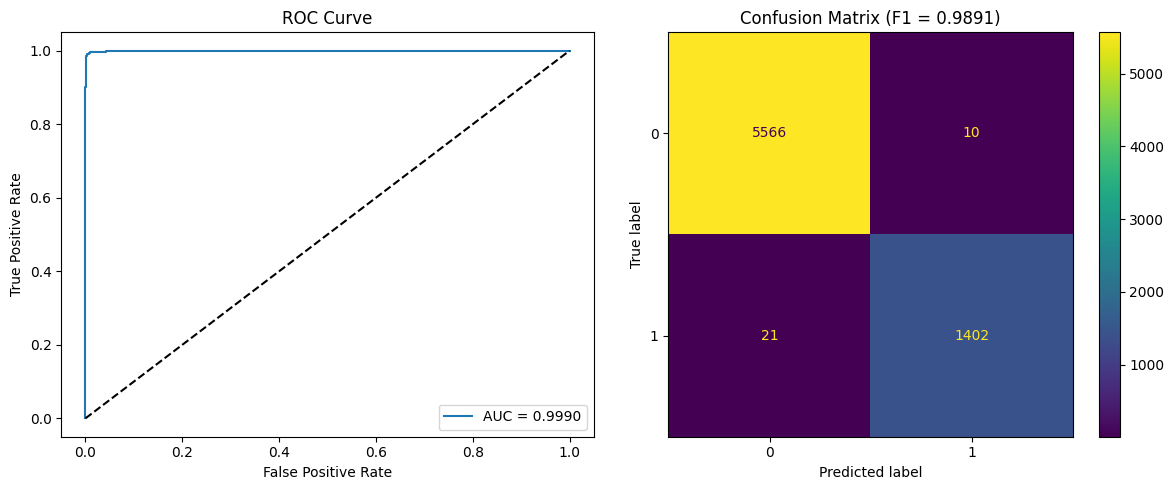

In [18]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Collect predictions and true labels
model.eval()
all_logits = []
all_targets = []

with torch.no_grad():
    for xb, yb in val_loader:
        logits = model(xb).squeeze()
        all_logits.extend(logits.tolist())
        all_targets.extend(yb.tolist())

# Convert logits to probabilities
probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
preds = (probs > 0.5).astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_targets, probs)
auc_score = roc_auc_score(all_targets, probs)

# Confusion Matrix
cm = confusion_matrix(all_targets, preds)
f1 = f1_score(all_targets, preds)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
axs[0].plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title("ROC Curve")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend()

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=axs[1], values_format='d')
axs[1].set_title(f"Confusion Matrix (F1 = {f1:.4f})")

plt.tight_layout()
plt.show()